# **Chiken Diseases Detection Using Convolutional Neural Networks**

1. **Final Project RMT 046**
- Data Scientist : Khairul Akbar

2. **Latar Belakang**

Keberhasilan peternakan ayam sangat tergantung pada kondisi kesehatan unggas dan pengendalian penyakit. Penyakit-pada-ayam seperti Coccidiosis, Salmonellosis, dan Newcastle disease dapat menyebabkan kematian unggas, menurunnya produktivitas (pertumbuhan lambat, penurunan telur) dan kerugian ekonomi yang signifikan.


3. **Dataset**

- Sumber : https://www.kaggle.com/datasets/efoeetienneblavo/chicken-disease-dataset
- Deskripsi : Dataset berisi gambar-gambar feses (kotoran) ayam yang terjangkit penyakit dan tidak, file bertipe jpg.

4. **Tujuan** 
- Pembuatan aplikasi berbasis ML untuk mengidentifikasi apakah unggas tesebut terjangkit penyakit atau tidak dengan memeriksa feses atau kotoran ayam tersebut dengan computer vision
- Aplikasi yg akan mengindentifikasi penyakit ungags dan memberikan rekomendasi penangganannya.

5. **User** 
- Peternak Ayam


# **A. Import Libraries**

In [2]:
# Import Libraries
import os, shutil, random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf

# Import Module
from PIL import Image
from tensorflow.keras.models import Model, Sequential
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Input

# **B. Exploratory Data Analysis (EDA)**

## **B.1 - BarPlot**

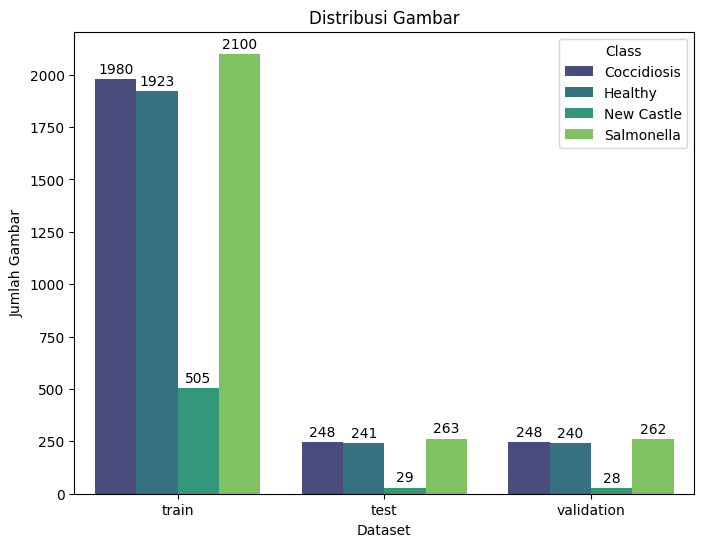

In [9]:
# Bar Plot
# Set path to dataset
path = "chicken_disease"

# Set subfolders
subfolders = ["train", "test", "validation"]

# Create empty dataframe
data_textures = []

# Iterate over subfolders
for subfolder in subfolders:
    cocci_files = os.listdir(os.path.join(path, subfolder, "Coccidiosis"))
    cocci_count = len(cocci_files)
    
    healthy_files = os.listdir(os.path.join(path, subfolder, "Healthy"))
    healthy_count = len(healthy_files)
    
    new_castle_files = os.listdir(os.path.join(path, subfolder, "New Castle Disease"))
    new_castle_count = len(new_castle_files)
    
    salmon_files = os.listdir(os.path.join(path, subfolder, "Salmonella"))
    salmon_count = len(salmon_files)

    data_textures.append({"Dataset": subfolder, "Class": "Coccidiosis", "Count": cocci_count})
    data_textures.append({"Dataset": subfolder, "Class": "Healthy", "Count": healthy_count})
    data_textures.append({"Dataset": subfolder, "Class": "New Castle", "Count": new_castle_count})
    data_textures.append({"Dataset": subfolder, "Class": "Salmonella", "Count": salmon_count})

# Convert to DataFrame
df_textures = pd.DataFrame(data_textures)

# Plot with seaborn
plt.figure(figsize=(8,6))
ax = sns.barplot(data=df_textures, x="Dataset", y="Count", hue="Class", palette="viridis")

# Tambahkan angka di atas bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=10, padding=2)

plt.title("Distribusi Gambar")
plt.ylabel("Jumlah Gambar")
plt.xlabel("Dataset")
plt.show()


## **B.2 - PieChart**

C:\Users\USER\AppData\Local\Temp\ipykernel_11732\672885637.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub["Count"] = df_sub["Count"].astype(int)
C:\Users\USER\AppData\Local\Temp\ipykernel_11732\672885637.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub["Count"] = df_sub["Count"].astype(int)
C:\Users\USER\AppData\Local\Temp\ipykernel_11732\672885637.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

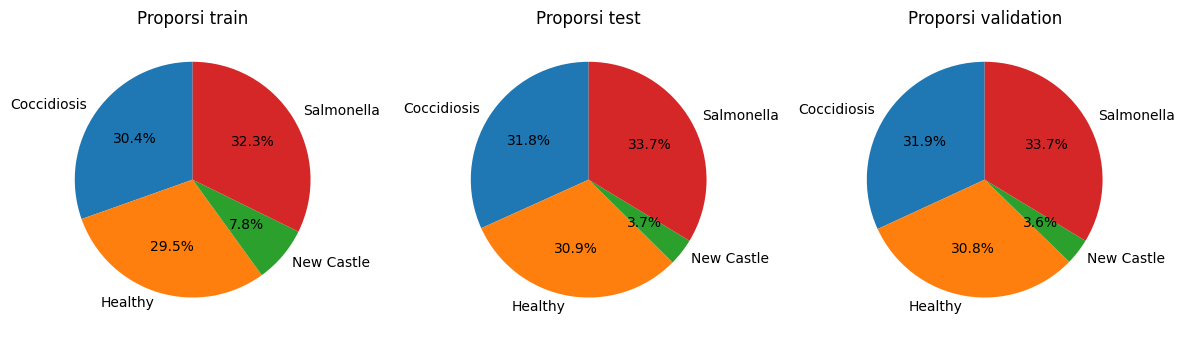

In [10]:
# Pie Chart
# Buat 2 pie chart dalam 1 figure
fig, axes = plt.subplots(1, 3, figsize=(12,6))

# Loop untuk training & testing
for i, subset in enumerate(subfolders):
    df_sub = df_textures[df_textures["Dataset"] == subset]
    df_sub["Count"] = df_sub["Count"].astype(int) 
    
    axes[i].pie(df_sub["Count"], labels=df_sub["Class"], autopct='%1.1f%%', startangle=90)
    axes[i].set_title(f"Proporsi {subset}")

plt.tight_layout()
plt.show()

## **B.3 - Menampilkan gambar dari tiap kelas**

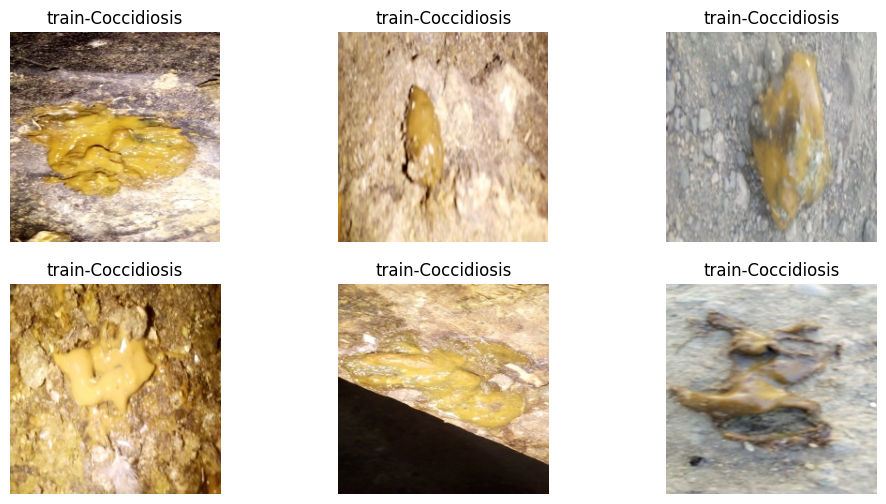

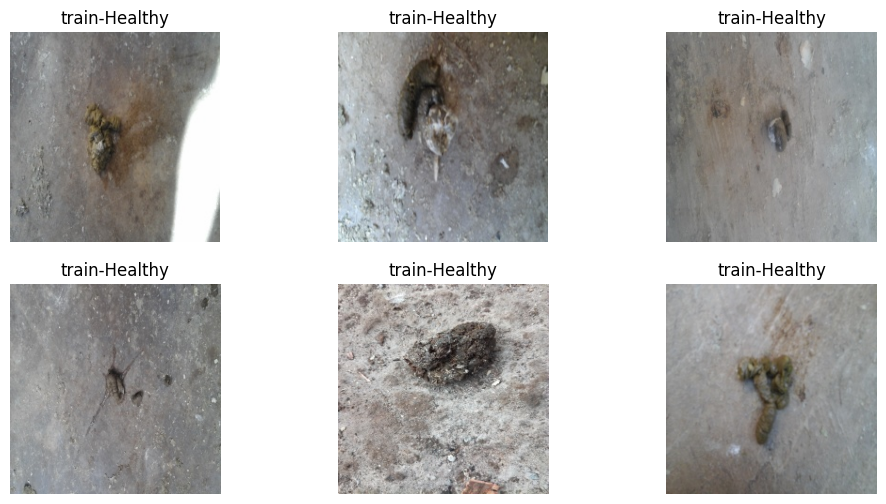

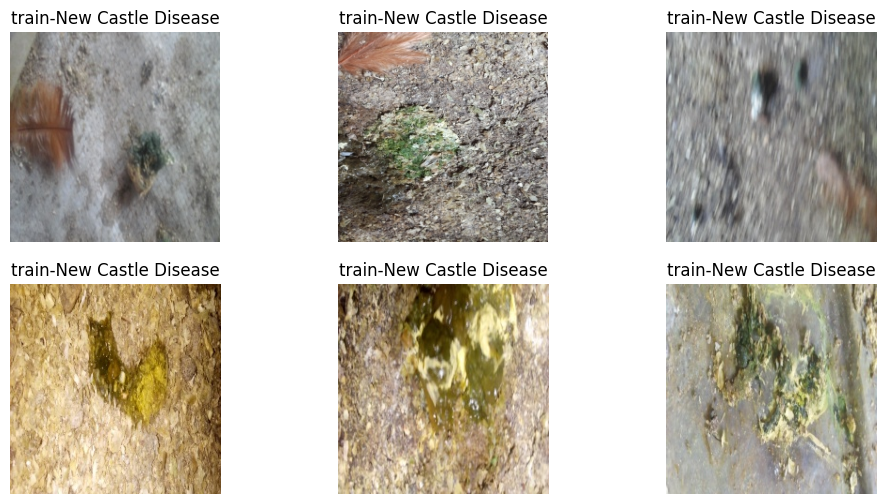

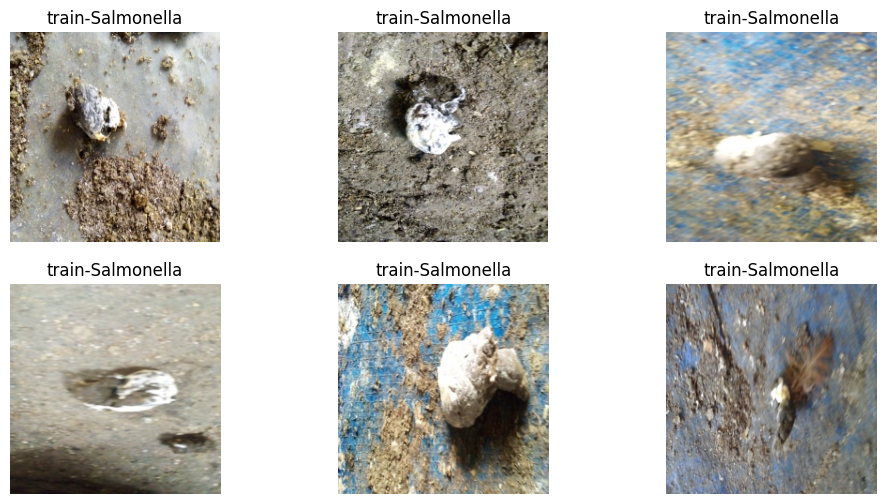

In [11]:
# Fungsi untuk menampilkan gambar random dari setiap kelas
def show_examples(base_path, subfolder, cls, n=6):
    files = os.listdir(os.path.join(base_path, subfolder, cls))
    samples = random.sample(files, min(n, len(files)))

    plt.figure(figsize=(12, 6))
    for i, file in enumerate(samples):
        img = Image.open(os.path.join(base_path, subfolder, cls, file))
        ax = plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{subfolder}-{cls}")
    plt.show()

path = "chicken_disease"

show_examples(path, "train", "Coccidiosis")
show_examples(path, "train", "Healthy")
show_examples(path, "train", "New Castle Disease")
show_examples(path, "train", "Salmonella")

## **B.4 - Analisa ukuran gambar**

        Width  Height
count  1057.0  1057.0
mean    224.0   224.0
std       0.0     0.0
min     224.0   224.0
25%     224.0   224.0
50%     224.0   224.0
75%     224.0   224.0
max     224.0   224.0


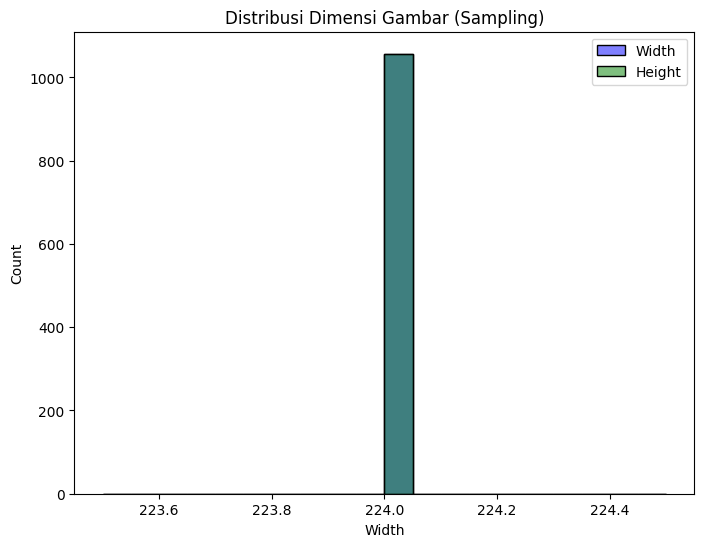

In [12]:
# Analisa ukuran gambar, output yang dihasilkan berupa pixel (per 100 gambar)
image_shapes = []
for subfolder in ["test", "train", "validation"]:
    for cls in ["Coccidiosis", "Healthy", "New Castle Disease", "Salmonella"]:
        class_path = os.path.join(path, subfolder, cls)
        files = os.listdir(class_path)
        for f in files[:100]:  # ambil sampling 100 gambar saja
            img = Image.open(os.path.join(class_path, f))
            image_shapes.append(img.size)  # (width, height)

df_shapes = pd.DataFrame(image_shapes, columns=["Width", "Height"])
print(df_shapes.describe())

plt.figure(figsize=(8,6))
sns.histplot(df_shapes["Width"], bins=20, kde=True, color="blue", label="Width")
sns.histplot(df_shapes["Height"], bins=20, kde=True, color="green", label="Height")
plt.legend()
plt.title("Distribusi Dimensi Gambar (Sampling)")
plt.show()


## **B.5 - Analisis intensitas warna (histogram grayscale)**

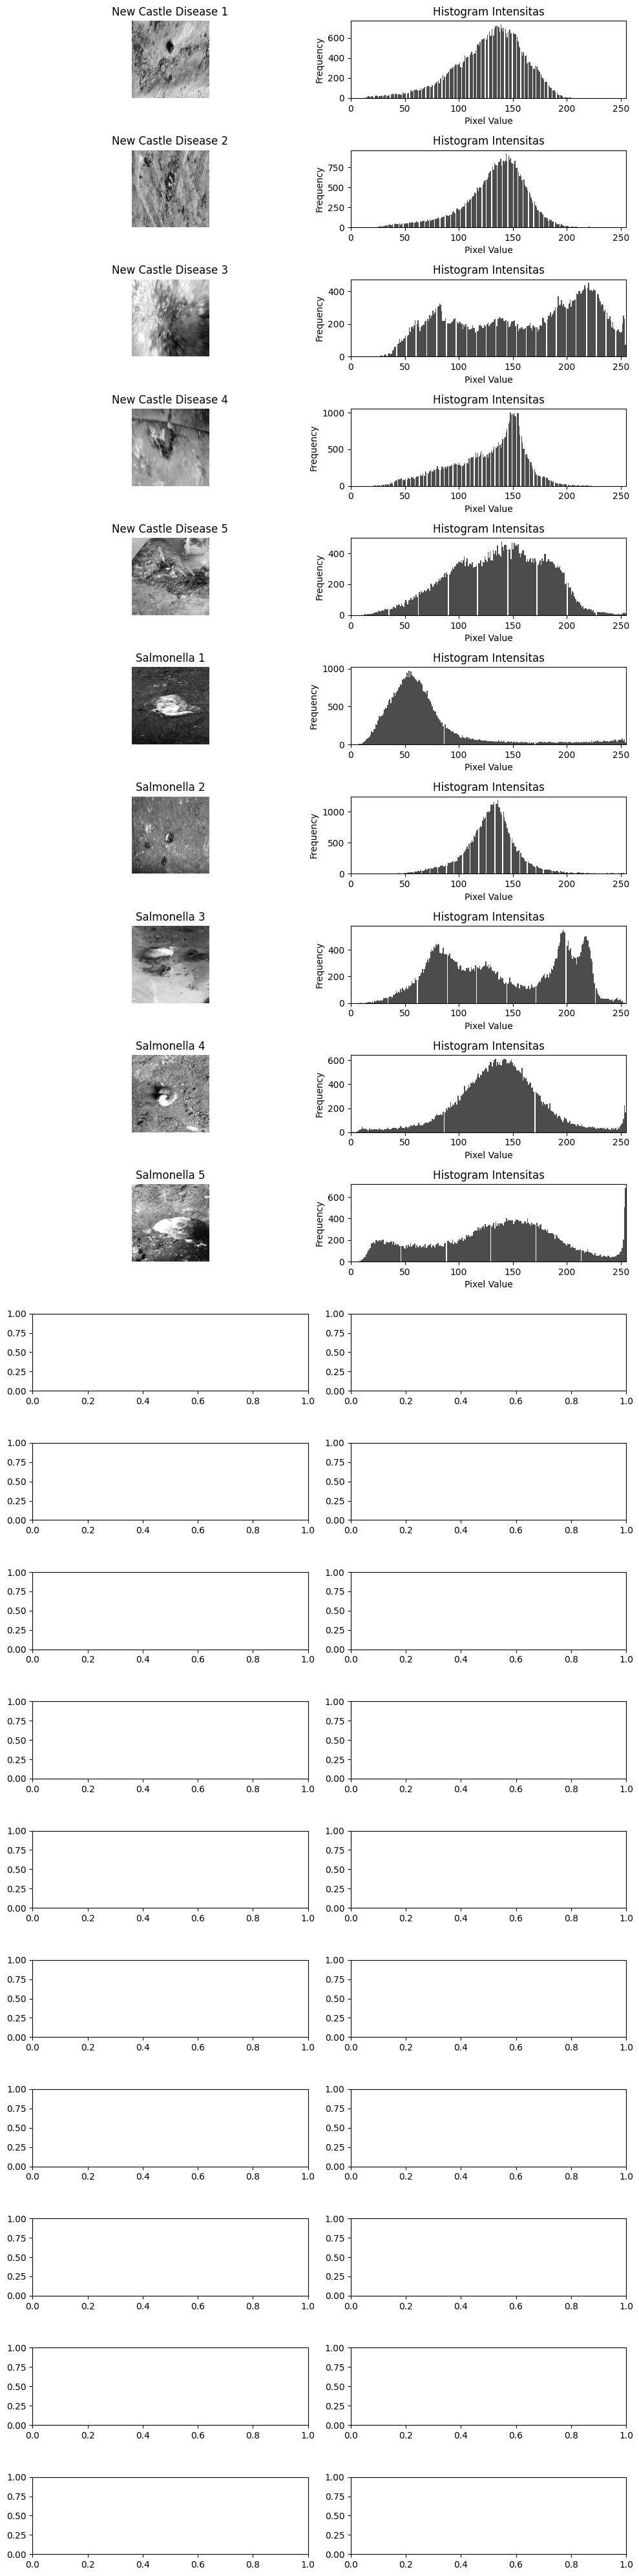

In [14]:
# Fungsi untuk menampilkan gambar + histogram grayscale
def show_image_and_hist(image_path, ax_img, ax_hist, title=""):
    img = Image.open(image_path).convert("L")  # grayscale
    arr = np.array(img)

    # Tampilkan gambar
    ax_img.imshow(arr, cmap="gray")
    ax_img.axis("off")
    ax_img.set_title(title)

    # Tampilkan histogram grayscale
    ax_hist.hist(arr.ravel(), bins=256, color="black", alpha=0.7)
    ax_hist.set_xlim(0, 255)
    ax_hist.set_title("Histogram Intensitas")
    ax_hist.set_xlabel("Pixel Value")
    ax_hist.set_ylabel("Frequency")

# Path dataset
path = "chicken_disease"

# Ambil 5 sample cracked dan 5 normal
cocci_samples = random.sample(os.listdir(os.path.join(path, "train", "Coccidiosis")), 5)
healthy_samples  = random.sample(os.listdir(os.path.join(path, "train", "Healthy")), 5)
new_castle_samples = random.sample(os.listdir(os.path.join(path, "train", "New Castle Disease")), 5)
salmon_samples  = random.sample(os.listdir(os.path.join(path, "train", "Salmonella")), 5)

samples = [(os.path.join(path, "train", "Coccidiosis", f), f"Coccidiosis {i+1}") for i, f in enumerate(cocci_samples)]
samples += [(os.path.join(path, "train", "Healthy", f), f"Healthy {i+1}") for i, f in enumerate(healthy_samples)]
samples = [(os.path.join(path, "train", "New Castle Disease", f), f"New Castle Disease {i+1}") for i, f in enumerate(new_castle_samples)]
samples += [(os.path.join(path, "train", "Salmonella", f), f"Salmonella {i+1}") for i, f in enumerate(salmon_samples)]

# Plot 10 gambar + histogram (10 baris, 2 kolom)
fig, axes = plt.subplots(20, 2, figsize=(10, 40))

for i, (img_path, title) in enumerate(samples):
    show_image_and_hist(img_path, axes[i,0], axes[i,1], title)

plt.tight_layout()
plt.show()